# Imports and Device Setup

In [18]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
import noisereduce as nr
import soundfile as sf
from collections import Counter
import pandas as pd
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Exact Dataset Path

In [19]:
dataset_path = r"C:\Users\Jim\Jupiter Projects\CSE499\BanglaMOOD_processed"
reduced_audio_path = r"D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Noise Reduced Data"
augmented_audio_path = r"D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Augmented Data"

# Data Preprocessing Functions

In [20]:
def standardize_audio(file_path, target_length=5, sample_rate=48000, trim_threshold=30, max_amplitude=0.9):
    try:
        # Load audio, resample to 16 kHz, convert to mono
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # Standardize length to 5 seconds
        target_samples = int(target_length * sample_rate)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]
        
        # Trim silence (post-length adjustment to refine)
        waveform, _ = librosa.effects.trim(waveform, top_db=trim_threshold)
        # Re-pad if trimming makes it too short
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        
        # Normalize volume
        if waveform.max() > 0:
            waveform = waveform / waveform.max() * max_amplitude
        
        return waveform, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        raise

def augment_to_target(paths, labels, target_count=500, augmented_base_path=augmented_audio_path):
    print("Starting augmentation...")
    label_counts = Counter(labels)
    all_paths, all_labels = [], []
    
    for label in label_counts:
        original_count = label_counts[label]
        print(f"Label {label}: {original_count} original samples")
        label_dir = os.path.join(augmented_base_path, label)
        os.makedirs(label_dir, exist_ok=True)
        
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        label_paths = [p for p, l in zip(paths, labels) if l == label]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Truncating to {target_count} samples for {label} (had {total_current})")
            # Combine original and augmented paths
            combined_paths = label_paths + [os.path.join(label_dir, f) for f in existing_files]
            combined_labels = [label] * len(combined_paths)
            # Randomly select target_count samples
            indices = np.random.choice(len(combined_paths), target_count, replace=False)
            selected_paths = [combined_paths[i] for i in indices]
            selected_labels = [combined_labels[i] for i in indices]
            all_paths.extend(selected_paths)
            all_labels.extend(selected_labels)
            continue
        
        # Clear existing files if augmentation needed
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        print(f"  Cleared {len(existing_files)} existing files in {label_dir} (needed {target_count}, had {total_current})")
        
        needed = target_count - original_count
        aug_types = ["pitch_1", "pitch_2", "pitch_neg_1", "pitch_neg_2", "stretch_1.05", "stretch_1.1", "noise_0.005"]
        if label in ["disappointment", "excitement"]:
            aug_types.extend(["pitch_3", "pitch_neg_3", "stretch_1.15", "noise_0.01"])  # Additional augmentations
        aug_idx = 0
        
        aug_paths, aug_labels = [], []
        while needed > 0 and aug_idx < target_count * 2:
            orig_idx = aug_idx // len(aug_types) % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            waveform, sr = standardize_audio(label_paths[orig_idx])
            base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
            
            if aug_type.startswith("pitch"):
                n_steps = float(aug_type.split("_")[1]) if "neg" not in aug_type else -float(aug_type.split("_")[2])
                augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                file_name = f"{base_name}_pitch_{n_steps}_{aug_idx}.wav"
            elif aug_type.startswith("stretch"):
                rate = float(aug_type.split("_")[1])
                augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                file_name = f"{base_name}_stretch_{rate}_{aug_idx}.wav"
            elif aug_type.startswith("noise"):
                noise_level = float(aug_type.split("_")[1])
                noise = np.random.normal(0, noise_level, waveform.shape)
                augmented = waveform + noise
                file_name = f"{base_name}_noise_{noise_level}_{aug_idx}.wav"
            
            aug_path = os.path.join(label_dir, file_name)
            sf.write(aug_path, augmented, sr)
            aug_paths.append(aug_path)
            aug_labels.append(label)
            needed -= 1
            aug_idx += 1
        
        # Combine original and new augmented paths, then select target_count
        combined_paths = label_paths + aug_paths
        combined_labels = [label] * len(combined_paths)
        indices = np.random.choice(len(combined_paths), target_count, replace=False)
        selected_paths = [combined_paths[i] for i in indices]
        selected_labels = [combined_labels[i] for i in indices]
        all_paths.extend(selected_paths)
        all_labels.extend(selected_labels)
        
        print(f"  Augmented {label} to {len([l for l in all_labels if l == label])} samples")
    
    total_samples = len(all_paths)
    print(f"Total augmented samples: {total_samples}")
    if total_samples != 8 * target_count:
        print(f"Warning: Generated {total_samples} samples, expected {8 * target_count}")
    return all_paths, all_labels

def reduce_noise(waveform, sr, output_path, label):
    if label in ["fear", "disgust", "disappointment"]:
        reduced = nr.reduce_noise(y=waveform, sr=sr, prop_decrease=0.3)
    else:
        reduced = nr.reduce_noise(y=waveform, sr=sr, prop_decrease=0.7)
    sf.write(output_path, reduced, sr)
    if not os.path.exists(output_path):
        raise Exception(f"Failed to write {output_path}")
    return output_path

# Dataset Loading Functions

In [21]:
def load_banglamood_dataset(dataset_path, target_length=5):
    paths, labels = [], []
    emotion_folders = ["Happy", "Sad", "Angry", "Neutral", "Surprised", "Fear", "disappointment", "Excitement"]
    
    for emotion in emotion_folders:
        emotion_path = os.path.join(dataset_path, emotion)
        if not os.path.isdir(emotion_path):
            print(f"Skipping {emotion_path}: not a directory")
            continue
        num_files = len([f for f in os.listdir(emotion_path) if f.endswith(".wav")])
        print(f"{emotion}: {num_files} files")
        for file in os.listdir(emotion_path):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_path, file)
                paths.append(file_path)
                labels.append(emotion.lower())
    print(f"BanglaMOOD: {len(paths)} files loaded")
    return paths, labels

def process_and_reduce_noise(paths, labels, reduced_base_path):
    reduced_paths, reduced_labels = [], []
    for path, label in zip(paths, labels):
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist, skipping")
            continue
        label_dir = os.path.join(reduced_base_path, label)
        os.makedirs(label_dir, exist_ok=True)
        base_name = os.path.basename(path).replace(".wav", "_reduced.wav")
        reduced_file = os.path.join(label_dir, base_name)
        if not os.path.exists(reduced_file):
            waveform, sr = standardize_audio(path)
            reduce_noise(waveform, sr, reduced_file, label)
        reduced_paths.append(reduced_file)
        reduced_labels.append(label)
    print(f"Total reduced samples: {len(reduced_paths)}")
    return reduced_paths, reduced_labels

# Feature Extraction and Dataset Class

In [22]:
def extract_combined_features(file_path, sample_rate=48000, n_mfcc=60, n_mels=80, n_frames=500):
    waveform, sr = librosa.load(file_path, sr=sample_rate)
    
    # MFCC
    mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=len(waveform)//(n_frames-1))
    if mfcc.shape[1] < n_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, n_frames - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :n_frames]
        
    # MEL FREQ
    mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels, hop_length=len(waveform)//(n_frames-1))
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    if log_mel.shape[1] < n_frames:
        log_mel = np.pad(log_mel, ((0, 0), (0, n_frames - log_mel.shape[1])), mode='constant')
    else:
        log_mel = log_mel[:, :n_frames]
    return np.concatenate((mfcc, log_mel), axis=0)  # Shape: (140, 300)

def compute_features_in_memory(paths):
    features = []
    for file_path in paths:
        feat = extract_combined_features(file_path)
        features.append(feat)
    return features

class AudioDataset(Dataset):
    def __init__(self, features, labels, label_map):
        self.features = features
        self.labels = [label_map[l] for l in labels]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        
def reduce_noise(waveform, sr, output_path, label):
    if label in ["fear", "disappointment", "excitement"]:
        reduced = nr.reduce_noise(y=waveform, sr=sr, prop_decrease=0.3)
    else:
        reduced = nr.reduce_noise(y=waveform, sr=sr, prop_decrease=0.7)
    sf.write(output_path, reduced, sr)
    if not os.path.exists(output_path):
        raise Exception(f"Failed to write {output_path}")
    return output_path

def process_and_reduce_noise(paths, labels, reduced_base_path):
    reduced_paths, reduced_labels = [], []
    for path, label in zip(paths, labels):
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist, skipping")
            continue
        label_dir = os.path.join(reduced_base_path, label)
        os.makedirs(label_dir, exist_ok=True)
        base_name = os.path.basename(path).replace(".wav", "_reduced.wav")
        reduced_file = os.path.join(label_dir, base_name)
        if not os.path.exists(reduced_file):
            waveform, sr = standardize_audio(path)
            reduce_noise(waveform, sr, reduced_file, label)
        reduced_paths.append(reduced_file)
        reduced_labels.append(label)
    print(f"Total reduced samples: {len(reduced_paths)}")
    return reduced_paths, reduced_labels

# Model Definition

In [23]:
class CNNBackbones(nn.Module):
    def __init__(self):
        super(CNNBackbones, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv1d(140, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.pool1 = nn.MaxPool1d(2)
        self.block2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.pool2 = nn.AdaptiveMaxPool1d(31)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        return x

class CNNTransformerHybrid(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNTransformerHybrid, self).__init__()
        self.cnn = CNNBackbones()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128, nhead=4, dim_feedforward=512, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(31 * 256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1) # Switches dimensions to [batch, time, features] format expected by Transformer
        transformer_out = self.transformer(transformer_in)
        combined = torch.cat((cnn_out.permute(0, 2, 1), transformer_out), dim=-1)
        combined = combined.reshape(combined.size(0), -1)
        out = self.fc(combined)
        return out

# Training and Evaluation Functions

In [24]:
# [batch, features, time]
# Input: (64, 80, 300)
# CNN Block 1 Conv: (64, 64, 300)
# CNN Block 1 Pool: (64, 64, 150)
# CNN Block 2 Conv: (64, 128, 150)
# CNN Block 2 Pool: (64, 128, 31)
# [batch, time, features]
# Transformer Input: (64, 31, 128)
# Transformer Output: (64, 31, 128)
# Fusion Concat: (64, 31, 256)
# Fusion Flatten: (64, 7936)
# FC Linear 1: (64, 512)
# FC Linear 2: (64, 7)

In [25]:
def train_model(model, train_loader, val_loader, num_epochs=500, patience=20):
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=15, min_lr=1e-6)
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 8.0], dtype=torch.float32).to(device)  # Higher weights for disappointment, excitement
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1).to(device)
    
    best_val_accuracy = -float('inf')
    best_model_state = None
    patience_counter = 0
    save_path = "CSE499_BanglaMOOD_Modelv3.pth"
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        scheduler.step(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            patience_counter = 0
            best_epoch = epoch
            print(f"  New best model saved to {save_path} with Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience counter: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            model.load_state_dict(best_model_state)
            break
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue', alpha=0.7)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', alpha=0.7)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='green', alpha=0.7)
    plt.axvline(x=best_epoch, color='r', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Training complete. Best Val Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}")
    return model

In [26]:
def evaluate_model(model, test_loader, label_map):
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    unique_labels = np.unique(all_labels)
    label_map_inv = {v: k for k, v in label_map.items()}
    present_classes = [label_map_inv[i] for i in unique_labels]

    print("Classes present in test set:", present_classes)
    print(classification_report(
        all_labels,
        all_preds,
        labels=unique_labels,
        target_names=present_classes,
        zero_division=0
    ))

    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_classes, yticklabels=present_classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    class_counts = np.bincount(all_labels, minlength=len(label_map))
    class_acc = [cm[i, i] / class_counts[unique_labels[i]] for i in range(len(unique_labels)) if class_counts[unique_labels[i]] > 0]
    weighted_acc = np.sum(class_acc * class_counts[unique_labels] / len(all_labels))
    print(f"Weighted Accuracy: {weighted_acc:.4f}")
    return weighted_acc

# Visualization of Class Distribution

In [27]:
def plot_class_distribution(original_labels, augmented_labels, label_map, title_suffix=""):
    plt.figure(figsize=(12, 6))
    original_counts = Counter(original_labels)
    augmented_counts = Counter(augmented_labels)
    emotions = list(label_map.keys())
    original_values = [original_counts.get(emotion, 0) for emotion in emotions]
    augmented_values = [augmented_counts.get(emotion, 0) for emotion in emotions]
    df = pd.DataFrame({
        'Emotion': emotions * 2,
        'Count': original_values + augmented_values,
        'Dataset': ['Original'] * len(emotions) + ['Augmented'] * len(emotions)
    })
    ax = sns.barplot(x='Emotion', y='Count', hue='Dataset', data=df, palette=['#1f77b4', '#ff7f0e'])
    plt.title(f'Class Distribution Before and After Augmentation {title_suffix}', fontsize=14)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 5),
                   textcoords='offset points')
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

In [28]:
def plot_sample_features(dataset, label_map_inv, emotion=None, num_samples=2, sample_rate=48000, target_length=5, n_frames=300):
    if not dataset or len(dataset) == 0:
        print("Error: Dataset is empty")
        return
    
    plt.figure(figsize=(16, 6 * num_samples))
    sample_count = 0
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    
    # Compute hop_length for 5-second audio at 48 kHz
    hop_length = int((sample_rate * target_length) // (n_frames - 1))
    
    for idx in indices:
        if sample_count >= num_samples:
            break
        try:
            features, label_idx = dataset[idx]
            if emotion and label_map_inv[label_idx.item()] != emotion:
                continue
            features = features.numpy()
            if features.shape[0] != 140:  # 60 MFCC + 80 Mel
                print(f"Warning: Invalid feature shape {features.shape} for sample {idx}")
                continue
            emotion_label = label_map_inv[label_idx.item()]
            
            mfcc = features[:60]  # n_mfcc=60
            log_mel = features[60:]  # n_mels=80
            
            plt.subplot(num_samples, 2, sample_count * 2 + 1)
            librosa.display.specshow(mfcc, x_axis='time', sr=sample_rate, hop_length=hop_length, cmap='coolwarm')
            plt.colorbar(format='%+2.1f dB')
            plt.title(f'MFCCs - Emotion: {emotion_label}\n(Sample {idx})')
            plt.xlabel('Time (s)')
            plt.ylabel('MFCC Coefficients')
            
            plt.subplot(num_samples, 2, sample_count * 2 + 2)
            librosa.display.specshow(log_mel, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length, fmax=24000, cmap='magma')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Log-Mel Spectrogram - Emotion: {emotion_label}\n(Sample {idx})')
            plt.xlabel('Time (s)')
            plt.ylabel('Mel Frequency')
            
            sample_count += 1
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            continue
    
    if sample_count == 0:
        print(f"No samples found for emotion: {emotion}")
    plt.tight_layout()
    plt.show()

def verify_class_distribution(original_labels, augmented_labels, label_map):
    original_counts = Counter(original_labels)
    augmented_counts = Counter(augmented_labels)
    emotions = list(label_map.keys())
    
    print("Original Class Counts:")
    for emotion in emotions:
        print(f"{emotion}: {original_counts.get(emotion, 0)} samples")
    
    print("\nAugmented Class Counts:")
    for emotion in emotions:
        print(f"{emotion}: {augmented_counts.get(emotion, 0)} samples")
    
    plot_class_distribution(original_labels, augmented_labels, label_map, title_suffix="(BanglaMOOD)")

# Main Execution

### Load Dataset and Augment

Happy: 294 files
Sad: 334 files
Angry: 621 files
Neutral: 685 files
Surprised: 273 files
Fear: 430 files
disappointment: 326 files
Excitement: 257 files
BanglaMOOD: 3220 files loaded
Original samples: 3220
Starting augmentation...
Label happy: 294 original samples
  Cleared 0 existing files in D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Augmented Data\happy (needed 685, had 294)
  Augmented happy to 685 samples
Label sad: 334 original samples
  Cleared 0 existing files in D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Augmented Data\sad (needed 685, had 334)
  Augmented sad to 685 samples
Label angry: 621 original samples
  Cleared 0 existing files in D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\Augmented Data\angry (needed 685, had 621)
  Augmented angry to 685 samples
Label neutral: 685 original samples
  Truncating to 685 samples for neutral (had 685)
Label surprised: 273 original samples
  Cleared 0 existing files in D:\Study\2025 Fall\CSE499\BanglaMOOD Temp Dataset\A

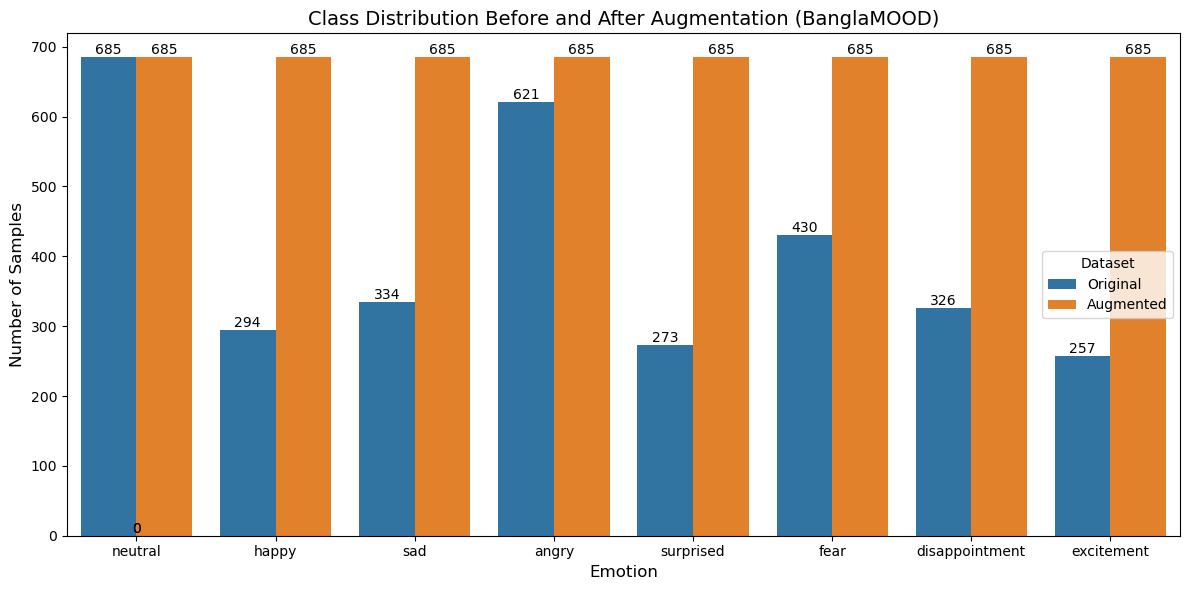

Applying noise reduction...
Total reduced samples: 5480
Class distribution after noise reduction:
neutral: 685 samples
happy: 685 samples
sad: 685 samples
angry: 685 samples
surprised: 685 samples
fear: 685 samples
disappointment: 685 samples
excitement: 685 samples
Computing features in memory...
Total samples: 5480
Dataset label counts: Counter({'happy': 685, 'sad': 685, 'angry': 685, 'neutral': 685, 'surprised': 685, 'fear': 685, 'disappointment': 685, 'excitement': 685})


In [29]:
# Load BanglaMOOD dataset
paths, labels = load_banglamood_dataset(dataset_path)
print(f"Original samples: {len(paths)}")

# Augment to 506 samples per class
augmented_paths, augmented_labels = augment_to_target(paths, labels, target_count=685)

# Define label map with 8 classes
label_map = {"neutral": 0, "happy": 1, "sad": 2, "angry": 3, "surprised": 4, "fear": 5, "disappointment": 6, "excitement": 7}
label_map_inv = {v: k for k, v in label_map.items()}

# Verify class distribution after augmentation
verify_class_distribution(labels, augmented_labels, label_map)

# Apply noise reduction
print("Applying noise reduction...")
reduced_paths, reduced_labels = process_and_reduce_noise(augmented_paths, augmented_labels, reduced_audio_path)

# Verify class distribution after noise reduction
print("Class distribution after noise reduction:")
reduced_label_counts = Counter(reduced_labels)
for emotion in label_map.keys():
    print(f"{emotion}: {reduced_label_counts.get(emotion, 0)} samples")

# Compute features in memory
print("Computing features in memory...")
all_features = compute_features_in_memory(reduced_paths)
dataset = AudioDataset(all_features, reduced_labels, label_map)
print(f"Total samples: {len(dataset)}")

# Debug dataset labels
label_counts = Counter([label_map_inv[dataset[i][1].item()] for i in range(len(dataset))])
print("Dataset label counts:", label_counts)

### Visualize

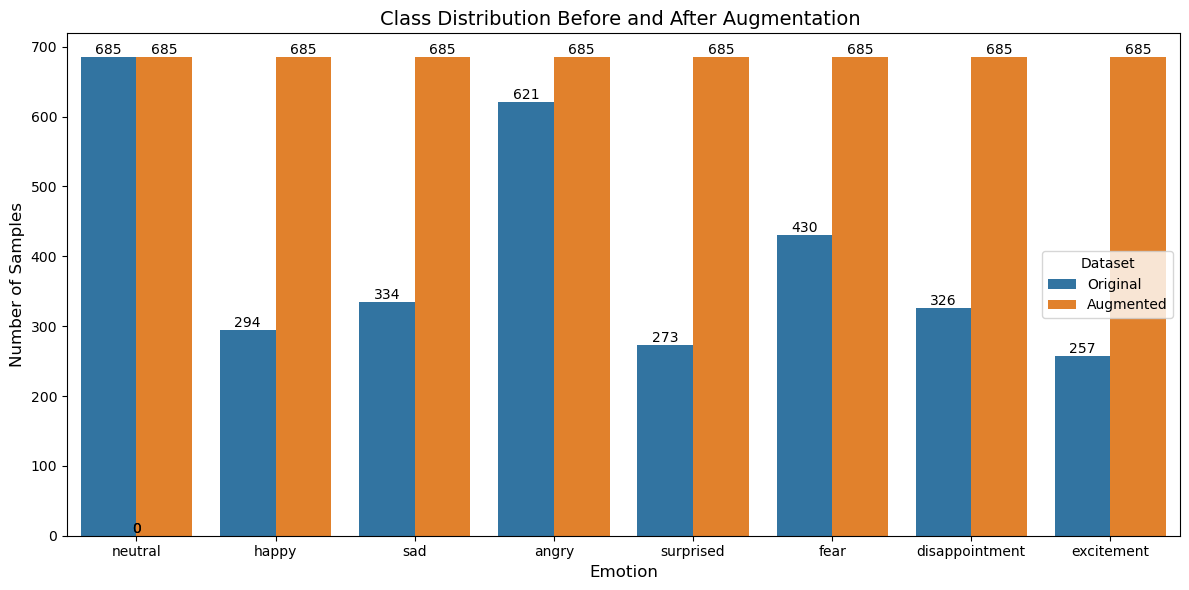

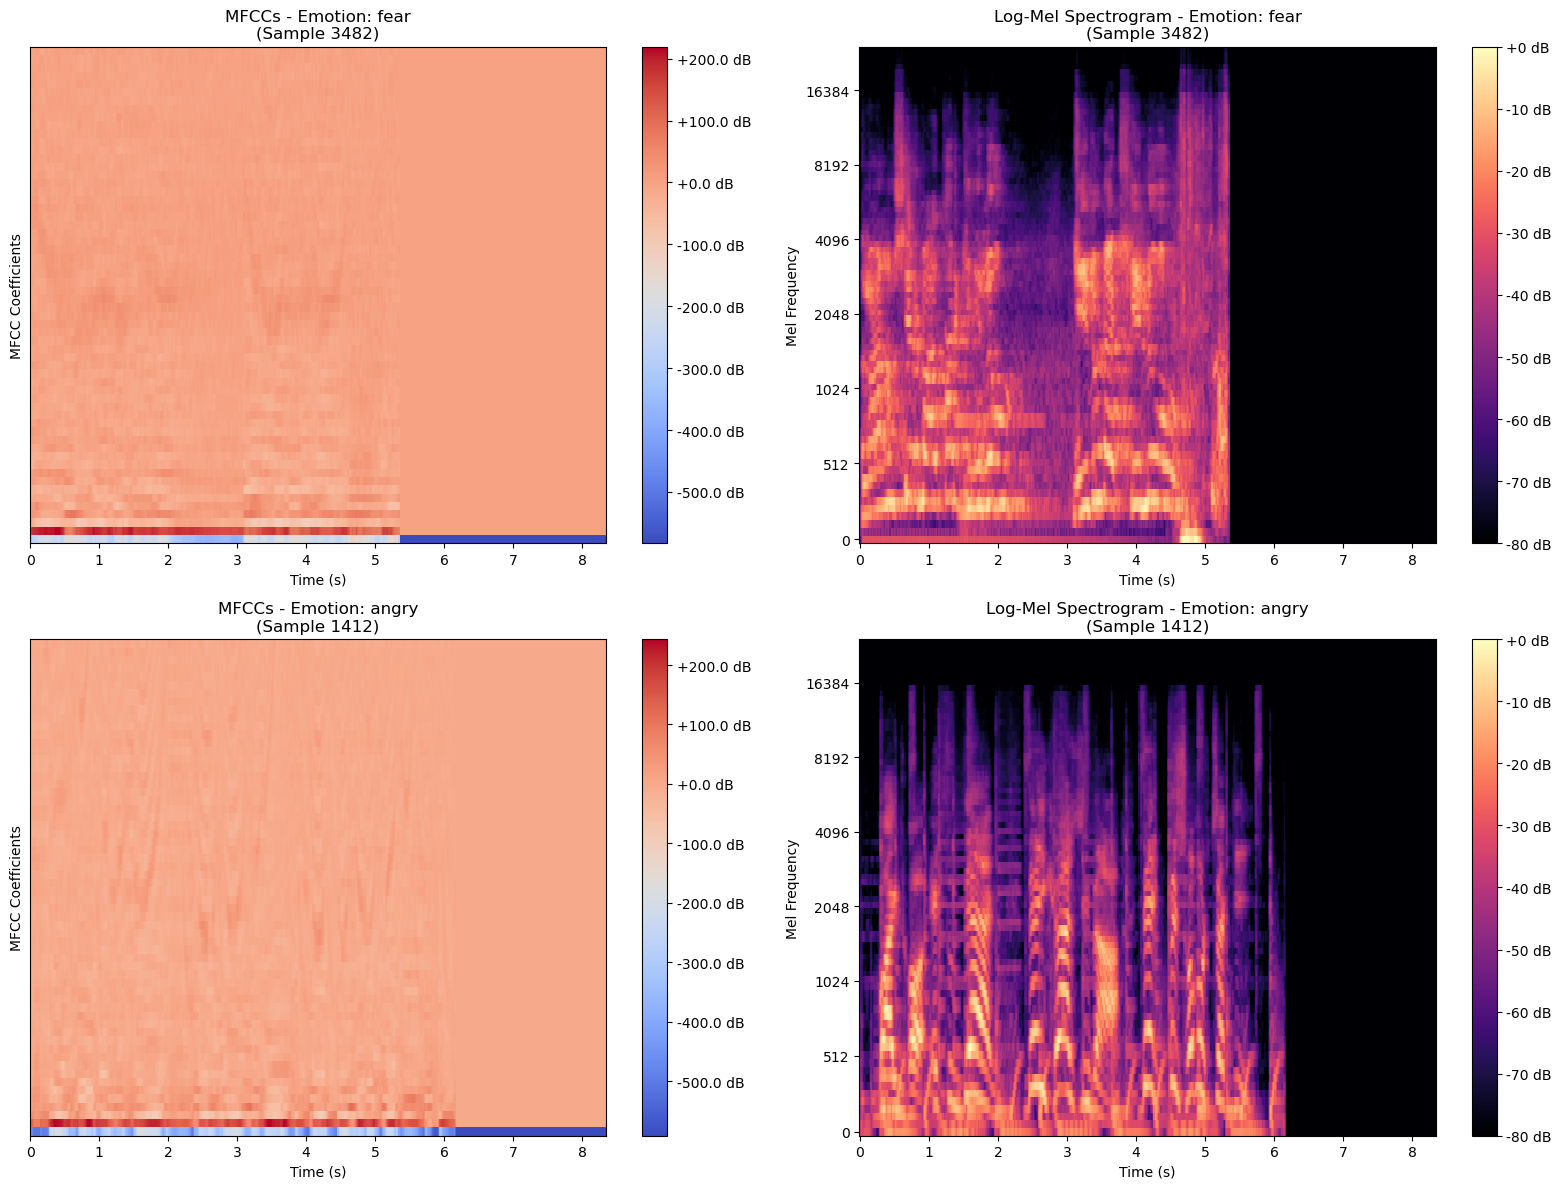

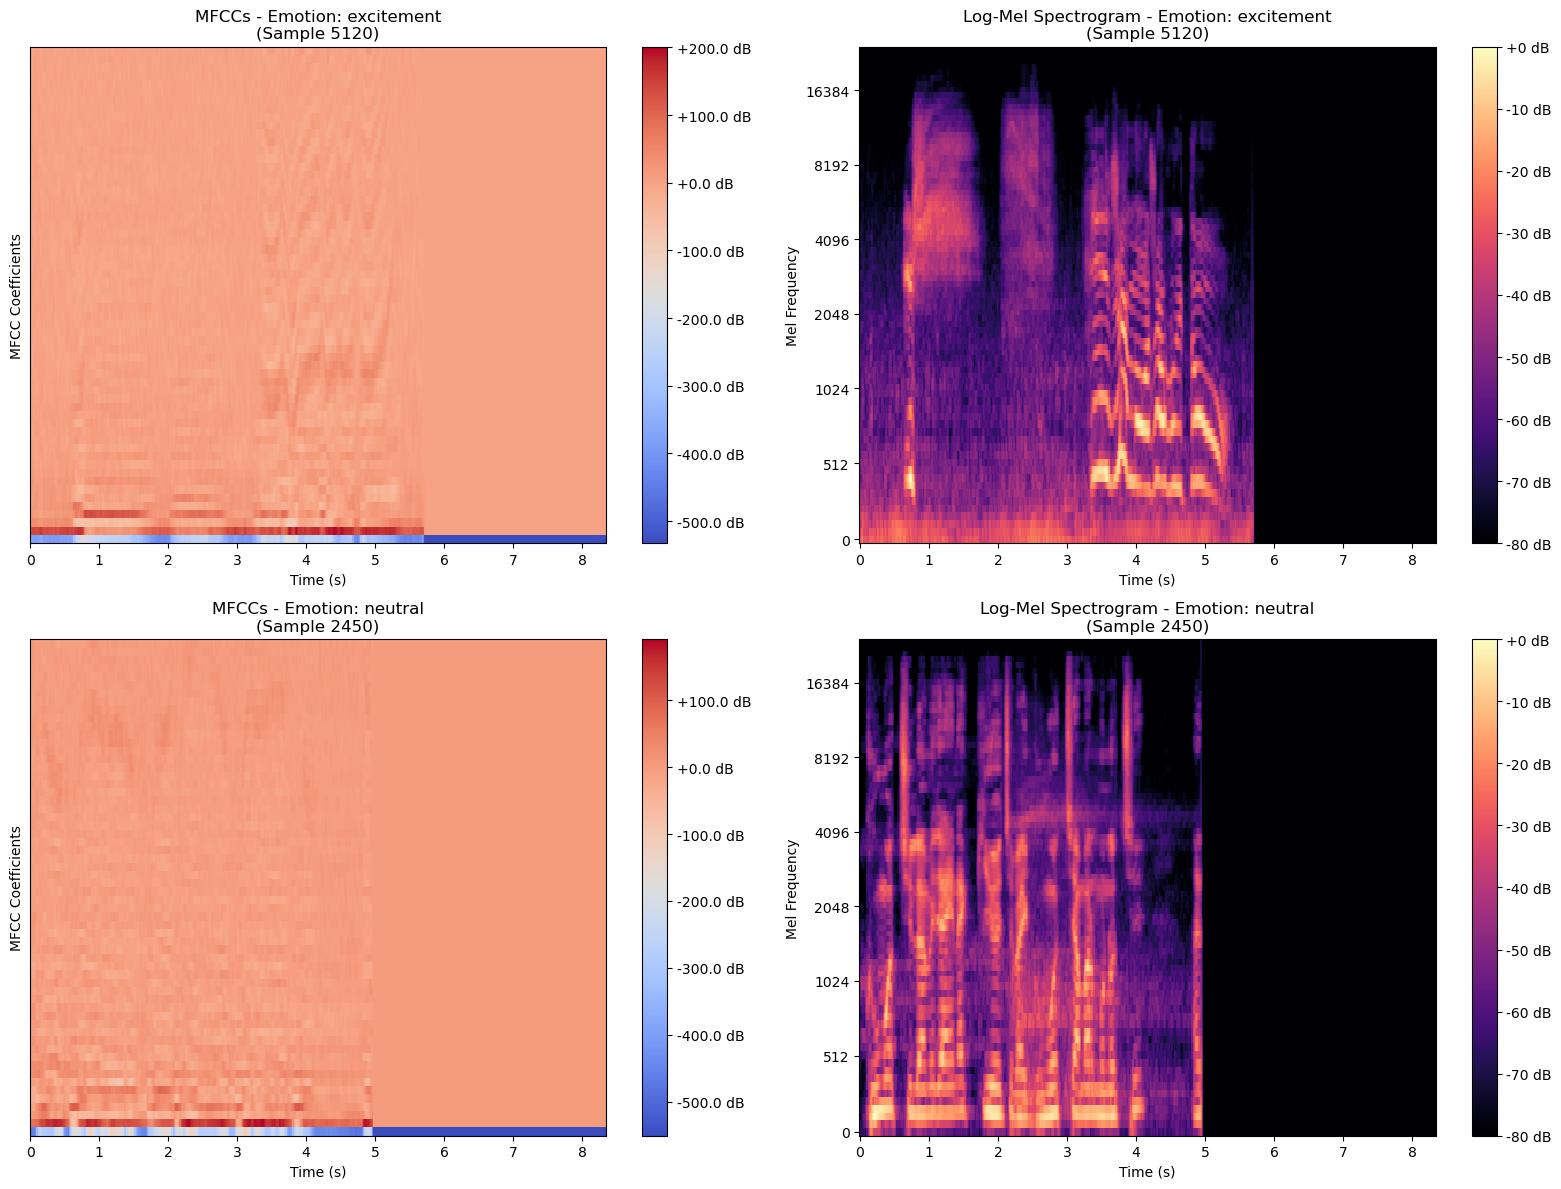

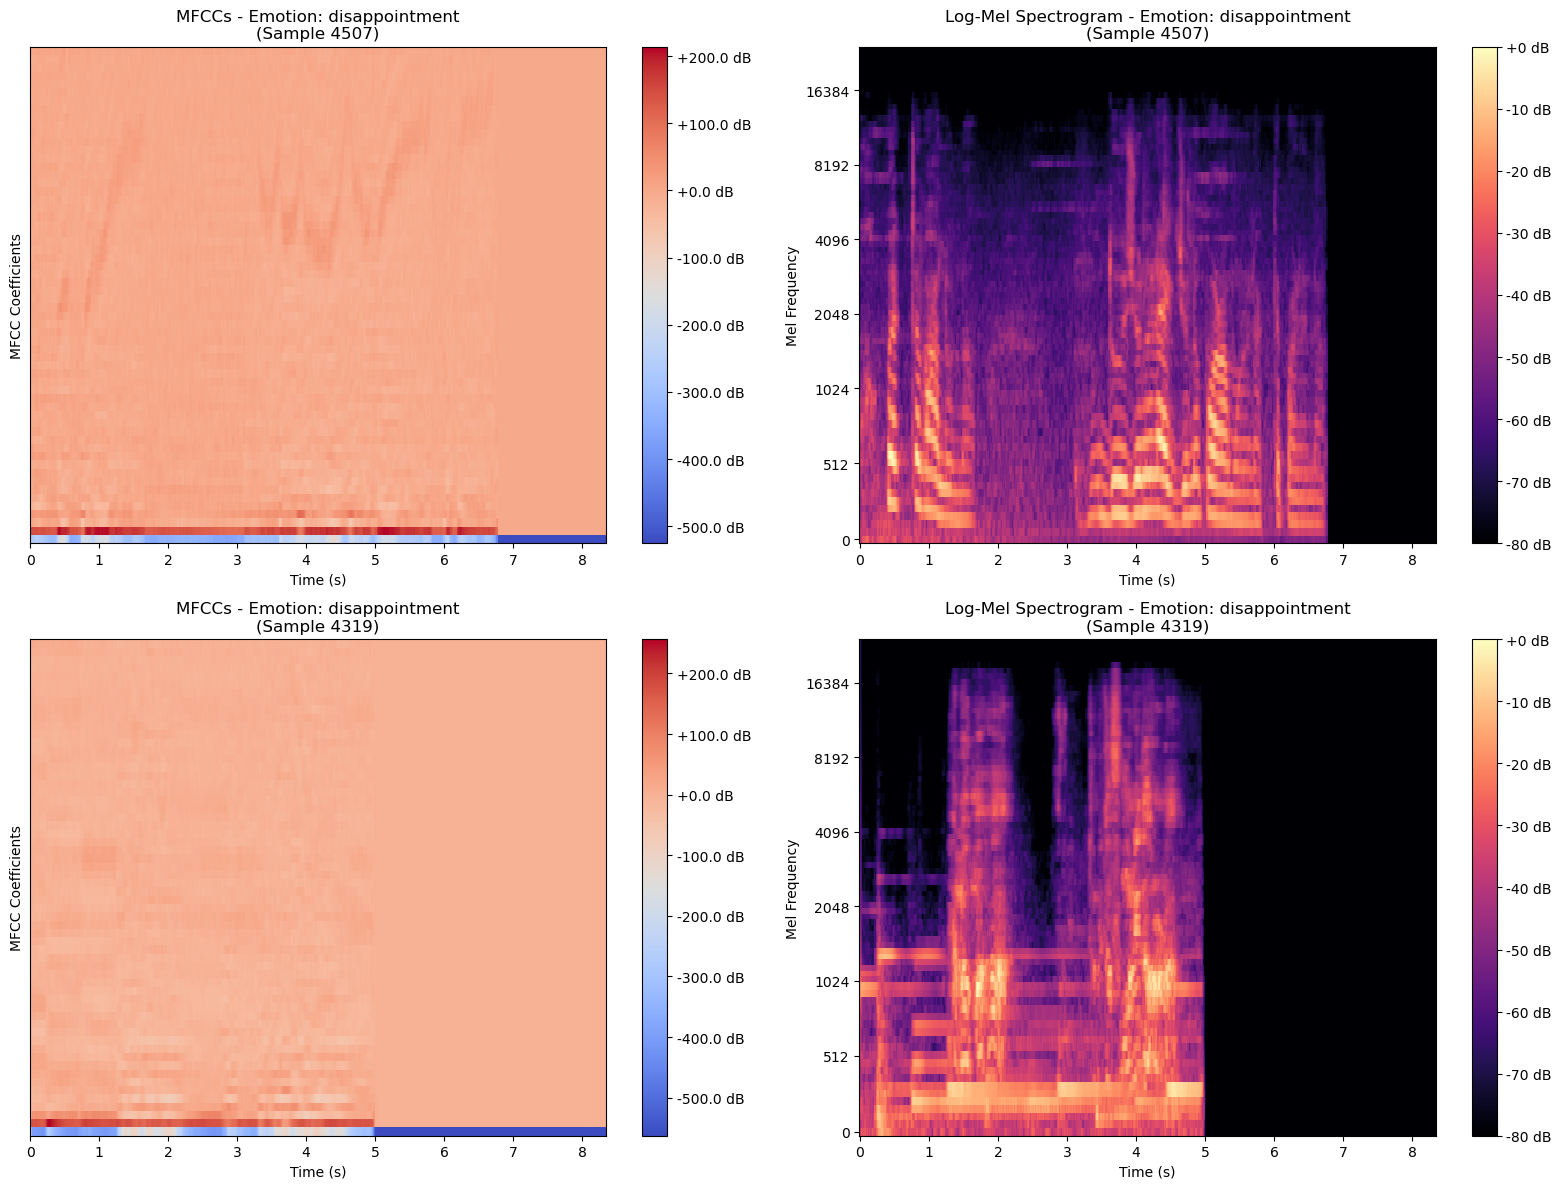

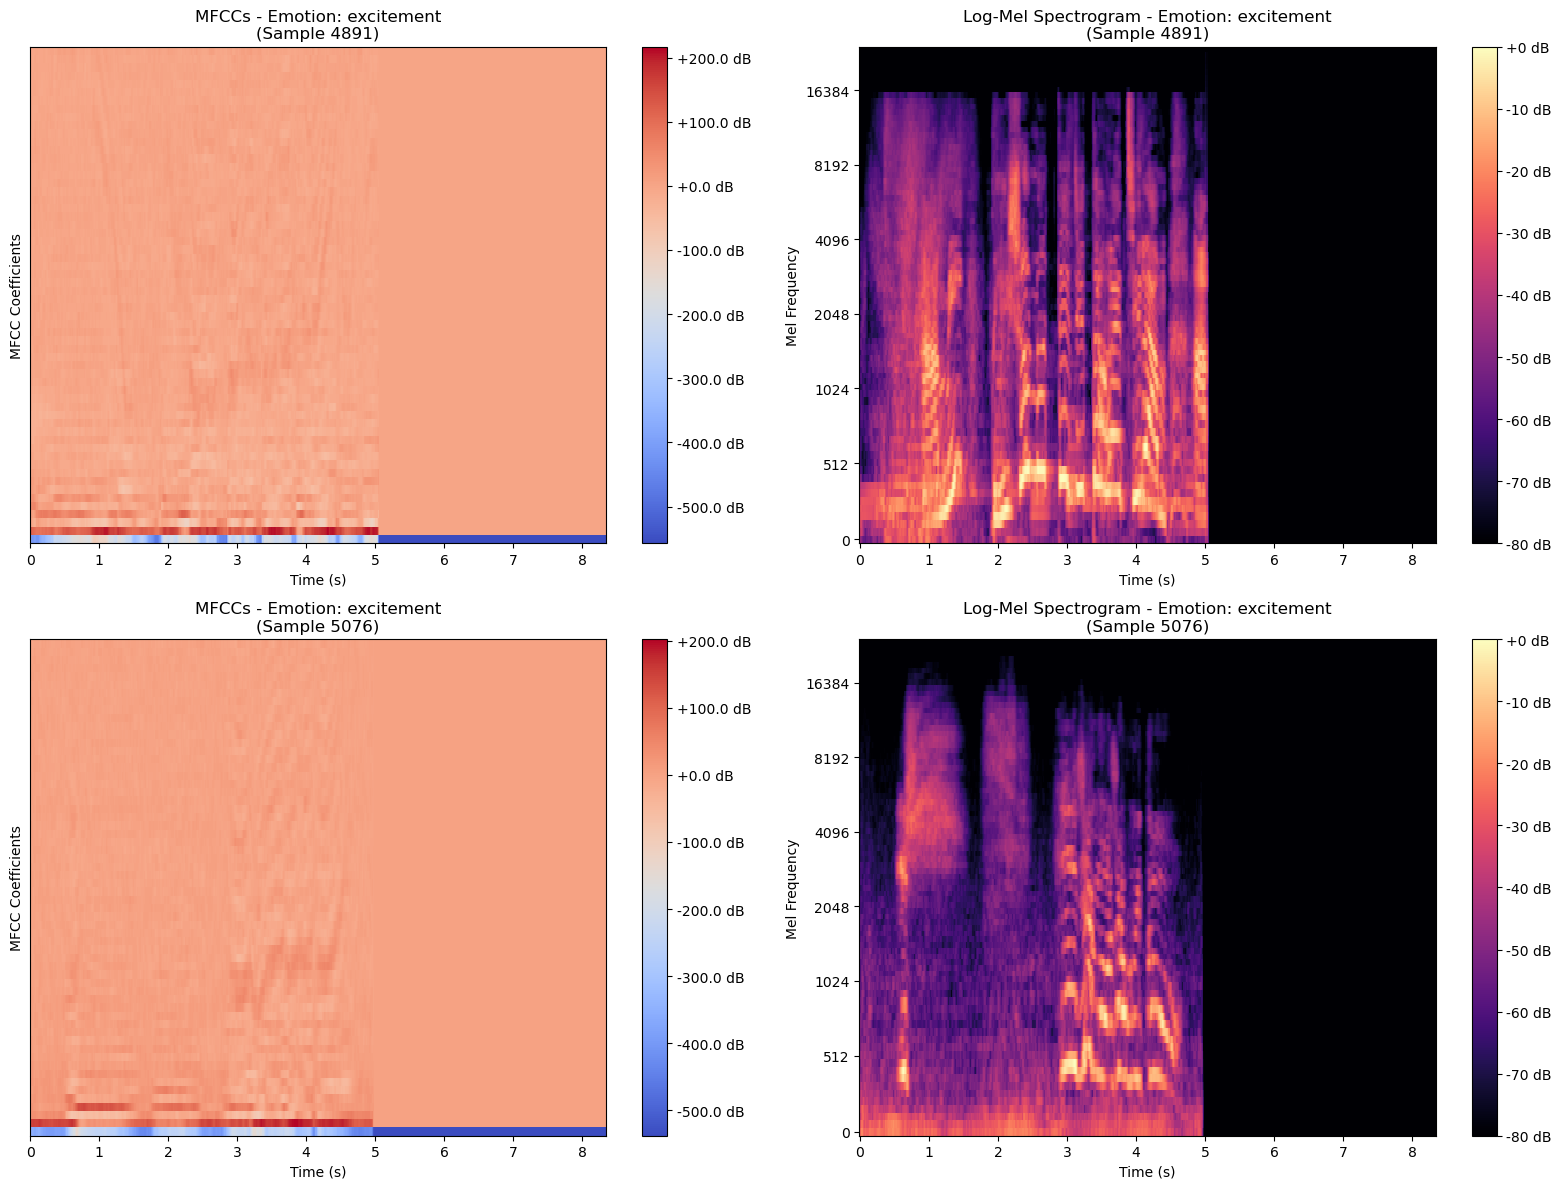

In [30]:
# Visualize class distribution
plot_class_distribution(labels, augmented_labels, label_map)

# Visualize random samples
plot_sample_features(dataset, label_map_inv)
plot_sample_features(dataset, label_map_inv)

# Visualize random samples for disappointment and excitement
plot_sample_features(dataset, label_map_inv, emotion="disappointment", num_samples=2)
plot_sample_features(dataset, label_map_inv, emotion="excitement", num_samples=2)

### Split and Prepare Data Loaders

In [31]:
# Stratified split
numerical_labels = [label_map[label] for label in augmented_labels]
print(f"Label distribution: {np.bincount(numerical_labels)}")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss.split(np.zeros(len(dataset)), numerical_labels))
train_val_labels = [numerical_labels[i] for i in train_val_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(train_val_idx)), train_val_labels))

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
test_labels = [dataset[i][1].item() for i in test_idx]
print(f"Test set label distribution: {np.bincount(test_labels)}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=0, pin_memory=True)
print(f"Train batches: {len(train_loader)}")

Label distribution: [685 685 685 685 685 685 685 685]
Train samples: 3836, Val samples: 548, Test samples: 1096
Test set label distribution: [137 137 137 137 137 137 137 137]
Train batches: 60


# Model Training and Evaluation

Total parameters: 4516424
Starting training...
Epoch 1/500, Train Loss: 2.2838, Val Loss: 1.9810, Train Accuracy: 0.2969, Val Accuracy: 0.4088, LR: 0.000500
  New best model saved to CSE499_BanglaMOOD_Modelv3.pth with Val Accuracy: 0.4088
Epoch 2/500, Train Loss: 1.8967, Val Loss: 2.3377, Train Accuracy: 0.4578, Val Accuracy: 0.2993, LR: 0.000500
  No improvement. Patience counter: 1/50
Epoch 3/500, Train Loss: 1.7675, Val Loss: 2.2257, Train Accuracy: 0.5279, Val Accuracy: 0.3157, LR: 0.000500
  No improvement. Patience counter: 2/50
Epoch 4/500, Train Loss: 1.6381, Val Loss: 2.4324, Train Accuracy: 0.5965, Val Accuracy: 0.3394, LR: 0.000500
  No improvement. Patience counter: 3/50
Epoch 5/500, Train Loss: 1.5513, Val Loss: 1.8399, Train Accuracy: 0.6423, Val Accuracy: 0.5310, LR: 0.000500
  New best model saved to CSE499_BanglaMOOD_Modelv3.pth with Val Accuracy: 0.5310
Epoch 6/500, Train Loss: 1.4648, Val Loss: 2.5023, Train Accuracy: 0.6872, Val Accuracy: 0.3230, LR: 0.000500
  No i

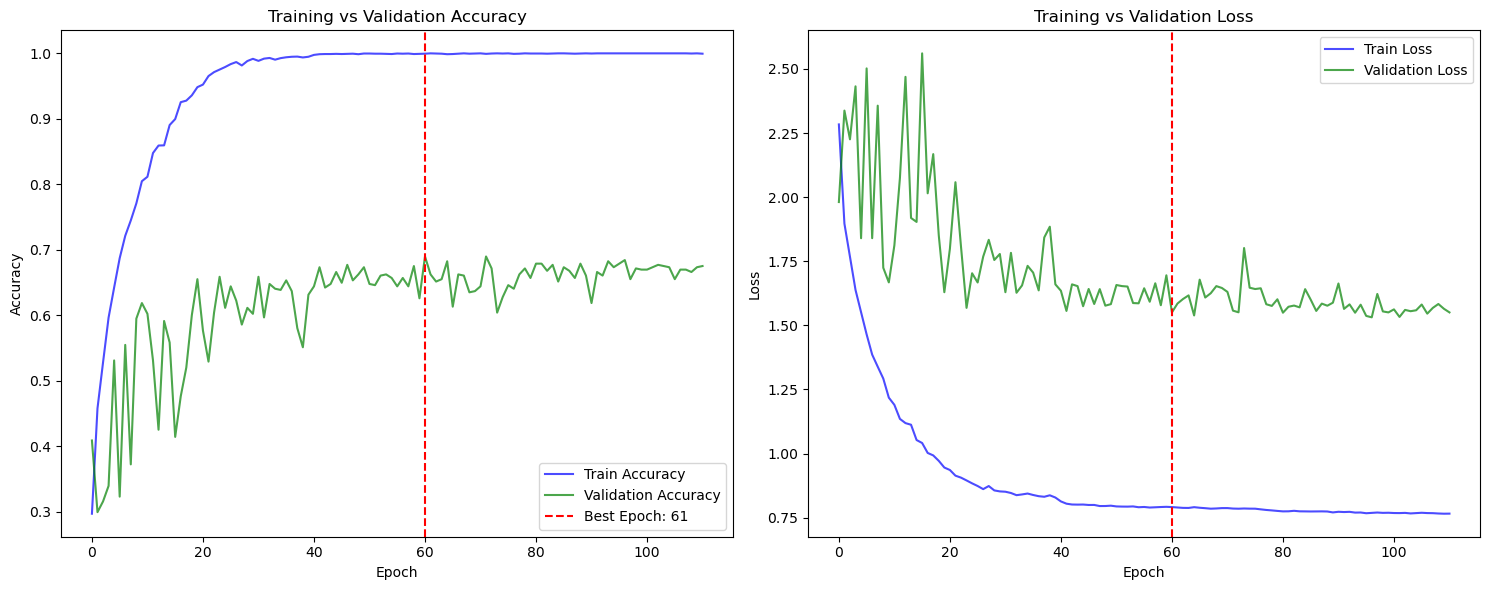

Training complete. Best Val Accuracy: 0.6898 at epoch 61
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprised', 'fear', 'disappointment', 'excitement']
                precision    recall  f1-score   support

       neutral       0.89      0.87      0.88       137
         happy       0.83      0.97      0.89       137
           sad       0.80      0.99      0.88       137
         angry       0.94      0.96      0.95       137
     surprised       0.87      0.97      0.92       137
          fear       0.69      0.99      0.81       137
disappointment       0.84      0.67      0.74       137
    excitement       0.48      0.12      0.19       137

      accuracy                           0.82      1096
     macro avg       0.79      0.82      0.78      1096
  weighted avg       0.79      0.82      0.78      1096



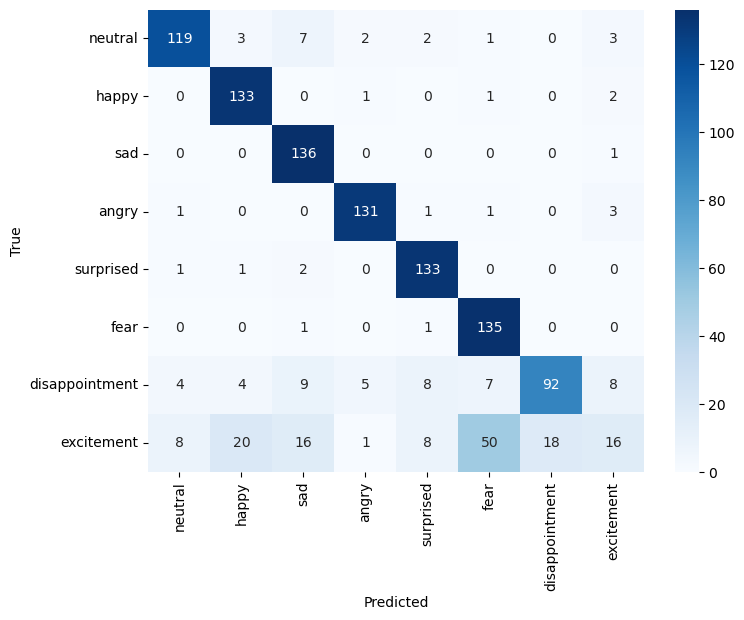

Weighted Accuracy: 0.8166


In [32]:
# Train and evaluate
torch.cuda.empty_cache()
model = CNNTransformerHybrid(num_classes=8).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
print("Starting training...")
model = train_model(model, train_loader, val_loader, num_epochs=500, patience=50)
weighted_acc = evaluate_model(model, test_loader, label_map)

In [33]:
# #Multiple runs (10 times)
# print("\nStarting 10-run evaluation...")
# weighted_accs = []
# num_runs = 10
# for run in range(num_runs):
#     print(f"\nRun {run + 1}/{num_runs}")
#     torch.cuda.empty_cache()
#     model = CNNTransformerHybrid(num_classes=7).to(device)  # Re-initialize model for random weights
#     model = train_model(model, train_loader, val_loader, num_epochs=500, patience=20)
#     weighted_acc = evaluate_model(model, test_loader, label_map)
#     weighted_accs.append(weighted_acc)

# # Compute mean and standard deviation
# mean_acc = np.mean(weighted_accs)
# std_acc = np.std(weighted_accs)
# print(f"\nResults over {num_runs} runs:")
# print(f"Mean Weighted Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

In [34]:
# import os
# from pydub import AudioSegment
# from mutagen.wave import WAVE
# from tqdm import tqdm
# import logging

# # === SETUP LOGGING ===
# logging.basicConfig(
#     level=logging.INFO,
#     filename="audio_conversion.log",
#     format="%(asctime)s - %(levelname)s - %(message)s"
# )

# # === PATH CONFIGURATION ===
# input_root = r"C:\Users\Jim\Jupiter Projects\CSE499\BanglaMOOD"
# output_root = r"C:\Users\Jim\Jupiter Projects\CSE499\BanglaMOOD_processed"

# # Specify ffmpeg path (update this to your ffmpeg.exe location)
# AudioSegment.ffmpeg = r"C:\ffmpeg\bin"  # Replace with actual path, e.g., r"C:\Program Files\ffmpeg\bin\ffmpeg.exe"

# # Create output root directory
# os.makedirs(output_root, exist_ok=True)

# # === TEST FILE READABILITY ===
# def is_file_readable(file_path):
#     try:
#         with open(file_path, 'rb') as f:
#             f.read(1)  # Try reading a single byte
#         return True
#     except Exception as e:
#         logging.error(f"Cannot read file {file_path}: {str(e)}")
#         return False

# # === WALK THROUGH EMOTION FOLDERS ===
# for root, dirs, files in os.walk(input_root):
#     # Filter WAV files
#     wav_files = [f for f in files if f.lower().endswith(".wav")]
    
#     if not wav_files:
#         logging.warning(f"No WAV files found in {root}")
#         print(f"No WAV files found in {root}")
#         continue
    
#     for file in tqdm(wav_files, desc=f"Processing files in {os.path.basename(root)}"):
#         input_path = os.path.join(root, file)
        
#         # Check if input file exists
#         if not os.path.exists(input_path):
#             logging.error(f"File not found: {input_path}")
#             print(f"Skipping {input_path}: File does not exist")
#             continue
        
#         # Check if file is readable
#         if not is_file_readable(input_path):
#             logging.error(f"File is not readable: {input_path}")
#             print(f"Skipping {input_path}: File is not readable")
#             continue
        
#         # Check file size
#         if os.path.getsize(input_path) == 0:
#             logging.error(f"File is empty: {input_path}")
#             print(f"Skipping {input_path}: File is empty")
#             continue
        
#         # Create output folder structure
#         relative_path = os.path.relpath(root, input_root)
#         output_folder = os.path.join(output_root, relative_path)
#         os.makedirs(output_folder, exist_ok=True)

#         output_path = os.path.join(output_folder, file)

#         try:
#             # Load and convert audio
#             audio = AudioSegment.from_wav(input_path)
#             audio = audio.set_channels(1).set_frame_rate(48000)
#             audio.export(output_path, format="wav")

#             # Remove metadata
#             audio_file = WAVE(output_path)
#             audio_file.delete()
#             audio_file.save()
#             logging.info(f"Successfully processed {input_path} -> {output_path}")
#             print(f"Processed {input_path}")

#         except Exception as e:
#             logging.error(f"Error processing {input_path}: {str(e)}")
#             print(f"Error processing {input_path}: {str(e)}")
#             continue